<a href="https://colab.research.google.com/github/sjquill/MSc_diss/blob/main/BREAST_Data/Breast_XGBSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-survival
!pip install scikit-survival xgboost
!pip install lifelines
!pip install xgbse

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [ ]:
import pandas as pd

breast_train_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_train_data_imputed1.csv")
breast_test_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_test_data_imputed1.csv")


In [ ]:
train_data = breast_train_data_imputed1.copy()
test_data = breast_test_data_imputed1.copy()

In [ ]:
column_names = [
    'mask_id',
    'disease_free_survival_status',
    'disease_free_survival_months',
    'race_asian',
    'race_black',
    'race_other',
    'Treatment_CA_6',
    'Treatment_T_4',
    'Treatment_T_6',
    'post_menopausal',
    'tumor_side_right',
    'tumor_side_bilateral',
    'receptor_status_er_pos',
    'receptor_status_pgrn_pos',
    'histologic_grade_inter',
    'histologic_grade_high',
    'her2_status_pos',
    'prior_hormonal_therapy_yes',
    'most_extensive_primary_surgery_mast_NOS',
    'tumor_size_2_to_5cm',
    'tumor_size_over_5cm',
    'num_pos_nodes_1',
    'num_pos_nodes_2+',
    'age_over_fifty'
]
# Set the new column names
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
import numpy as np

y_train = np.empty(len(train_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_train['disease_free_survival_status'] = train_data['disease_free_survival_status'].astype(bool)
y_train['disease_free_survival_months'] = train_data['disease_free_survival_months']

x_train = train_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])

# Repeat for test data.

y_test = np.empty(len(test_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_test['disease_free_survival_status'] = test_data['disease_free_survival_status'].astype(bool)
y_test['disease_free_survival_months'] = test_data['disease_free_survival_months']

x_test = test_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])


In [ ]:
## After the renaming of train and test data, this is the preprocessing required for xgbse.

from xgbse.converters import convert_to_structured

import pandas as pd

import numpy as np

y_train = np.empty(len(train_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_train['disease_free_survival_status'] = train_data['disease_free_survival_status'].astype(bool)
y_train['disease_free_survival_months'] = train_data['disease_free_survival_months']

x_train = train_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])

# Repeat for test data.

y_test = np.empty(len(test_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
y_test['disease_free_survival_status'] = test_data['disease_free_survival_status'].astype(bool)
y_test['disease_free_survival_months'] = test_data['disease_free_survival_months']

x_test = test_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])



# converting to structured format
y_train_months = pd.Series(y_train['disease_free_survival_months'])
y_train_status = pd.Series(y_train['disease_free_survival_status'])

y_train_structured = convert_to_structured(y_train_months, y_train_status)

# Repeat for test data
y_test_months = pd.Series(y_test['disease_free_survival_months'])
y_test_status = pd.Series(y_test['disease_free_survival_status'])

y_test_structured = convert_to_structured(y_test_months, y_test_status)

In [ ]:
## "XGBSEKaplanTree's" c-index isa good bit better than "XGBSEKaplanNeighbors"..? I wonder why
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)

# Initialize the model
params = {
    'objective': 'survival:cox',
    'max_depth': 3,
    'learning_rate': 0.1
}
xgbse_model = XGBSEDebiasedBCE(params)

# Fit the model
xgbse_model.fit(x_train, y_train_structured, num_boost_round=100)

# Predict
event_probs_train = xgbse_model.predict(x_train)
preds = xgbse_model.predict(x_test)


# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')

C-index: 0.6754393376140588
Avg. Brier Score: 0.07062461547357939


In [ ]:
print(preds[:3])

        2         11        20        29        38        47        57   \
0  0.999587  0.987230  0.957325  0.932843  0.911950  0.889336  0.872961   
1  0.999606  0.991610  0.974710  0.959895  0.942701  0.920799  0.903472   
2  0.999592  0.990576  0.973943  0.957472  0.938192  0.914912  0.897135   

        66        75        84        93        102  
0  0.856077  0.835358  0.821299  0.779988  0.626987  
1  0.885186  0.864790  0.849689  0.810752  0.647217  
2  0.880609  0.860520  0.845703  0.806595  0.645968  


In [ ]:
## "XGBSEKaplanTree's" c-index isa good bit better than "XGBSEKaplanNeighbors"..? I wonder why
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)

# Initialize the model
params = {
    'objective': 'survival:cox',
    'max_depth': 3,
    'learning_rate': 0.1
}
xgbse_model = XGBSEKaplanTree(params)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
event_probs_train = xgbse_model.predict(x_train)
preds = xgbse_model.predict(x_test)


# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')

C-index: 0.6792694604032894
Avg. Brier Score: 0.07061499898805602


In [ ]:
## "XGBSEKaplanTree's" c-index isa good bit better than "XGBSEKaplanNeighbors"..? I wonder why
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)

# Initialize the model
params = {
    'objective': 'survival:cox',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100
}
xgbse_model = XGBSEKaplanNeighbors(params)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
event_probs_train = xgbse_model.predict(x_train)
preds = xgbse_model.predict(x_test)


# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')

[23:41:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

C-index: 0.5793483158724795
Avg. Brier Score: 0.0734161327166418


In [ ]:
### Wrappers for tuning models

In [ ]:
from xgbse._debiased_bce import DEFAULT_PARAMS

In [ ]:
print(DEFAULT_PARAMS)

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'normal', 'aft_loss_distribution_scale': 1, 'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 8, 'booster': 'dart', 'subsample': 0.5, 'min_child_weight': 50, 'colsample_bynode': 0.5}


In [ ]:


from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)
# Wrapper class
class XGBSEModelWrapper(BaseEstimator):
    def __init__(self, objective='survival:cox', max_depth=3, learning_rate=0.1, subsample=0.5, min_child_weight=20, num_boost_round =1000):
        self.objective = objective
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.min_child_weight = min_child_weight
        self.num_boost_round = num_boost_round
        self.model = None

    def fit(self, X, y):
        xgb_params = {
            'objective': self.objective,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'min_child_weight': self.min_child_weight,
            'num_boost_round': self.num_boost_round
        }
        self.model = XGBSEDebiasedBCE(xgb_params=xgb_params)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return concordance_index(y, predictions)

# Define parameter grid
param_grid = {
    'max_depth': [2, 4, 10, 20],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.9],
    'min_child_weight': [10,30],
    'num_boost_round': [100, 200, 1000]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=XGBSEModelWrapper(),
    param_grid=param_grid,
    scoring=None,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(x_train, y_train_structured)

# Print best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Initialize the model with the best parameters
best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


C-index: 0.6480370620705194
Avg. Brier Score: 0.06986059673649346


In [ ]:


from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)


class XGBSEModelWrapper(BaseEstimator):
    def __init__(self,
                 objective='survival:cox',
                 max_depth=3,
                 learning_rate=0.1,
                 subsample=0.5,
                 min_child_weight=20,
                 num_boost_round=1000):
        self.objective = objective
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.min_child_weight = min_child_weight
        self.num_boost_round = num_boost_round
        self.model = None

    def fit(self, X, y):
        xgb_params = {
            'objective': self.objective,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'min_child_weight': self.min_child_weight
        }
        self.model = XGBSEDebiasedBCE(xgb_params=xgb_params)
        self.model.fit(X, y, num_boost_round=self.num_boost_round)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return concordance_index(y, predictions)

param_grid = {
    'max_depth': [2, 4],
    'learning_rate': [0.01, 0.2],
    'subsample': [0.5, 0.9],
    'min_child_weight': [10, 30],
    'num_boost_round': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=XGBSEModelWrapper(),
    param_grid=param_grid,
    scoring=None,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train_structured)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 30, 'num_boost_round': 100, 'subsample': 0.5}
Best score: 0.6059667855763349


In [ ]:

best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight'],
    num_boost_round=best_params['num_boost_round']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


C-index: 0.653387968908415
Avg. Brier Score: 0.07080754783999642


In [ ]:
print(y_test_structured[:1])

[(False, 95.34291581)]


<ipython-input-19-33eed0431b55>:23: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_time_col = surv_probs.columns.get_loc(t, method='nearest')
<ipython-input-19-33eed0431b55>:23: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_time_col = surv_probs.columns.get_loc(t, method='nearest')
<ipython-input-19-33eed0431b55>:23: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_time_col = surv_probs.columns.get_loc(t, method='nearest')
<ipython-input-19-33eed0431b55>:23: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_time_col = surv_probs.colum

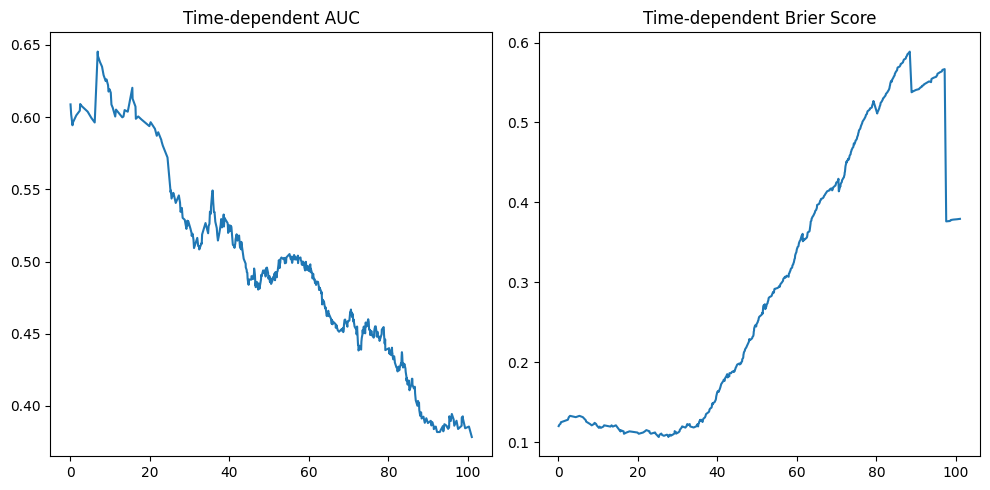

In [ ]:
from sklearn.metrics import roc_auc_score, brier_score_loss
import numpy as np
import pandas as pd

# Convert structured array to a 2D numpy array for easier handling
y_test_array = np.array(y_test_structured.tolist())

# Compute unique event times
event_times = np.unique(y_test_array[:, 1])

# Placeholder for results
time_dependent_auc = []
time_dependent_brier_score = []

for t in event_times:
    # Create a new label vector
    y_new = np.where(y_test_array[:, 1] <= t, y_test_array[:, 0], 1 - y_test_array[:, 0])

    # Predict the survival probabilities using the model
    surv_probs = xgbse_model.predict(x_test)

    # Find the closest time column in the survival probabilities DataFrame to the current time t
    closest_time_col = surv_probs.columns.get_loc(t, method='nearest')

    # Get the survival probabilities for the current time
    time_t_surv_probs = surv_probs.iloc[:, closest_time_col]

    # Compute and store AUC and Brier Score
    time_dependent_auc.append(roc_auc_score(y_new, time_t_surv_probs))
    time_dependent_brier_score.append(brier_score_loss(y_new, time_t_surv_probs))

# Convert results to numpy arrays
time_dependent_auc = np.array(time_dependent_auc)
time_dependent_brier_score = np.array(time_dependent_brier_score)

# .
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(event_times, time_dependent_auc)
plt.title('Time-dependent AUC')

plt.subplot(1, 2, 2)
plt.plot(event_times, time_dependent_brier_score)
plt.title('Time-dependent Brier Score')

plt.tight_layout()
plt.show()


In [ ]:
## check results of this and see how to add num_estimators or num_boost_rounds
class XGBSEModelWrapper(BaseEstimator):
    def __init__(self,
                 objective='survival:cox',
                 max_depth=3,
                 learning_rate=0.1,
                 subsample=0.5,
                 min_child_weight=20):
        self.objective = objective
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.min_child_weight = min_child_weight
        self.model = None

    def fit(self, X, y):
        xgb_params = {
            'objective': self.objective,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'min_child_weight': self.min_child_weight
        }
        self.model = XGBSEKaplanTree(xgb_params=xgb_params)
        self.model.fit(X, y)  # use the value from __init__
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return concordance_index(y, predictions)

param_grid = {
    'max_depth': [2, 5,10,100],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [10, 20, 30]
}

grid_search = GridSearchCV(
    estimator=XGBSEModelWrapper(),
    param_grid=param_grid,
    scoring=None,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train_structured)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 20, 'subsample': 1.0}
Best score: 0.5893897836672704


In [ ]:

best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


C-index: 0.6433902219218204
Avg. Brier Score: 0.07135337959605768


In [ ]:



from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)
## check results of this and see how to add num_estimators or num_boost_rounds
class XGBSEModelWrapper(BaseEstimator):
    def __init__(self,
                 objective='survival:cox',
                 max_depth=3,
                 learning_rate=0.1,
                 subsample=0.5,
                 min_child_weight=20):
        self.objective = objective
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.min_child_weight = min_child_weight
        self.model = None

    def fit(self, X, y):
        xgb_params = {
            'objective': self.objective,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'min_child_weight': self.min_child_weight
        }
        self.model = XGBSEKaplanTree(xgb_params=xgb_params)
        self.model.fit(X, y)  # use the value from __init__
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return concordance_index(y, predictions)

param_grid = {
    'max_depth': [2, 5,10,100],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [10, 20, 30]
}

grid_search = GridSearchCV(
    estimator=XGBSEModelWrapper(),
    param_grid=param_grid,
    scoring=None,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train_structured)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')



best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 20, 'subsample': 1.0}
Best score: 0.5893897836672704
C-index: 0.6433902219218204
Avg. Brier Score: 0.07135337959605768


In [ ]:

best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


C-index: 0.6433902219218204
Avg. Brier Score: 0.07135337959605768


In [ ]:
## 14/8/23Boostrapped resampling XGBSEDebiasedBCE. Also changing StratifiedKFold to --> KFold.

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, StratifiedKFold
from xgbse import XGBSEKaplanNeighbors, XGBSEKaplanTree, XGBSEDebiasedBCE
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)
class XGBSEModelWrapper(BaseEstimator):
    def __init__(self,
                 objective='survival:cox',
                 max_depth=3,
                 learning_rate=0.1,
                 subsample=0.5,
                 min_child_weight=20,
                 num_boost_round=1000):
        self.objective = objective
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.min_child_weight = min_child_weight
        self.num_boost_round = num_boost_round
        self.model = None

    def fit(self, X, y):
        xgb_params = {
            'objective': self.objective,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'subsample': self.subsample,
            'min_child_weight': self.min_child_weight
        }
        self.model = XGBSEDebiasedBCE(xgb_params=xgb_params)
        self.model.fit(X, y, num_boost_round=self.num_boost_round)  # use the value from __init__
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predictions = self.predict(X)
        return concordance_index(y, predictions)

param_grid = {
    'max_depth': [2, 4,6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.9],
    'min_child_weight': [10, 30, 50],
    'num_boost_round': [100, 200, 300]
}

grid_search = GridSearchCV(
    estimator=XGBSEModelWrapper(),
    param_grid=param_grid,
    scoring=None,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train_structured)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_params = grid_search.best_params_
xgbse_model = XGBSEModelWrapper(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    min_child_weight=best_params['min_child_weight'],
    num_boost_round=best_params['num_boost_round']
)

# Fit the model
xgbse_model.fit(x_train, y_train_structured)

# Predict
preds = xgbse_model.predict(x_test)

# running metrics
print(f'C-index: {concordance_index(y_test_structured, preds)}')
print(f'Avg. Brier Score: {approx_brier_score(y_test_structured, preds)}')


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 30, 'num_boost_round': 100, 'subsample': 0.5}
Best score: 0.6210070597494488
C-index: 0.6617241185085051
Avg. Brier Score: 0.07073160730501887


Bootstrap 95% confidence interval for the C-index: (0.63, 0.68)
Bootstrap 95% confidence interval for the Brier Score: (0.07, 0.09)


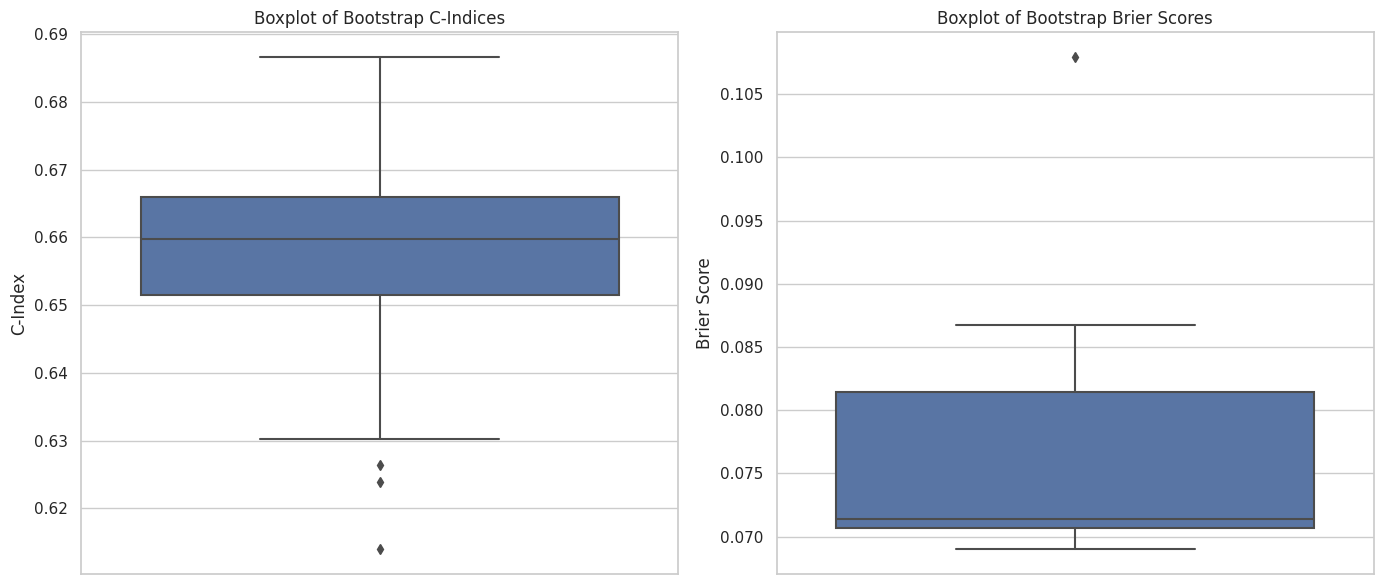

In [ ]:
## Boostrapped resampling XGBSEDebiasedBCE.


from sklearn.utils import resample
import numpy as np
from scipy.integrate import trapz

# Number of bootstrap iterations
n_bootstrap_iterations = 200

# Arrays to store bootstrap C-indices and Brier scores
bootstrap_c_indices_xgbse_breast = np.zeros(n_bootstrap_iterations)
bootstrap_brier_scores_xgbse_breast = np.zeros(n_bootstrap_iterations)

for i in range(n_bootstrap_iterations):
    # Perform bootstrap resampling of the training data
    bootstrap_train_x, bootstrap_train_y = resample(x_train, y_train_structured)

    # Fit the model using the resampled training data
    xgbse_model = XGBSEModelWrapper(
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        min_child_weight=best_params['min_child_weight'],
        num_boost_round=best_params['num_boost_round']
    )
    xgbse_model.fit(bootstrap_train_x, bootstrap_train_y)

    # Calculate C-index for the original test data and store it
    c_index = concordance_index(y_test_structured, xgbse_model.predict(x_test))
    bootstrap_c_indices_xgbse_breast[i] = c_index

    # Calculate Brier score for the original test data and store it
    brier_score = approx_brier_score(y_test_structured, xgbse_model.predict(x_test))
    bootstrap_brier_scores_xgbse_breast[i] = brier_score

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(bootstrap_c_indices_xgbse_breast, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_xgbse_breast, 97.5)

# Compute the lower and upper percentiles for Brier Score
lower_percentile_brier = np.percentile(bootstrap_brier_scores_xgbse_breast, 2.5)
upper_percentile_brier = np.percentile(bootstrap_brier_scores_xgbse_breast, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the Brier Score: ({:.2f}, {:.2f})'.format(lower_percentile_brier, upper_percentile_brier))

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=bootstrap_c_indices_xgbse_breast)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for Brier Score
plt.subplot(1, 2, 2)
sns.boxplot(y=bootstrap_brier_scores_xgbse_breast)
plt.title("Boxplot of Bootstrap Brier Scores")
plt.ylabel("Brier Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_xgbse_breast.npy', bootstrap_c_indices_xgbse_breast)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_brier_scores_xgbse_breast.npy', bootstrap_brier_scores_xgbse_breast)
